<a href="https://colab.research.google.com/github/sumayya-emaan/skills-copilot-codespaces-vscode/blob/main/AIDatacleaningandEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()  # upload both train.zip and dev.zip


Saving dev.zip to dev.zip
Saving train.zip to train.zip


In [4]:
import pandas as pd
import re
import os
import nltk
from nltk.stem import WordNetLemmatizer
from google.colab import files
import shutil
import zipfile

# --------------------------
# 0️⃣ Extract zip files correctly
# --------------------------
with zipfile.ZipFile("train.zip", "r") as zip_ref:
    zip_ref.extractall("train")

with zipfile.ZipFile("dev.zip", "r") as zip_ref:
    zip_ref.extractall("dev")

# --------------------------
# 1️⃣ Download NLTK resources
# --------------------------
nltk.download('wordnet')

# --------------------------
# 2️⃣ Multilingual-safe text cleaning (with emoji removal)
# --------------------------
lemmatizer = WordNetLemmatizer()

def remove_emojis(text):
    """Remove emojis from text (Unicode ranges for faces, symbols, flags, etc.)."""
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002700-\U000027BF"  # dingbats
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text_multilang(text):
    """
    Clean text for multilingual data — removes URLs, mentions, hashtags, emojis,
    and extra spaces while preserving all languages and punctuation.
    """
    text = str(text)
    text = remove_emojis(text)
    text = re.sub(r"http\S+|www\S+", "", text)       # URLs
    text = re.sub(r"@\w+", "", text)                 # mentions
    text = re.sub(r"#", "", text)                    # hashtags
    text = re.sub(r"[\"“”]", "", text)               # fancy quotes
    text = re.sub(r"\s+", " ", text).strip()         # normalize spaces
    return text

def preprocess_safe(text):
    """
    Apply English lemmatization only — other languages remain untouched.
    """
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# --------------------------
# 3️⃣ Create output folders
# --------------------------
cleaned_train_folder = "cleaned_train"
cleaned_dev_folder = "cleaned_dev"

os.makedirs(cleaned_train_folder, exist_ok=True)
os.makedirs(cleaned_dev_folder, exist_ok=True)

# --------------------------
# 4️⃣ Helper: find all CSVs recursively
# --------------------------
def find_csv_files(folder):
    csv_files = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(".csv"):
                csv_files.append(os.path.join(root, f))
    return csv_files

# --------------------------
# 5️⃣ Clean all CSVs
# --------------------------
def clean_files_multilang(input_folder, output_folder, prefix):
    csv_files = find_csv_files(input_folder)
    for path in csv_files:
        filename = os.path.basename(path)
        print(f"🧼 Cleaning {filename} ...")

        df = pd.read_csv(path)

        # Detect the text column automatically
        text_cols = [c for c in df.columns if 'text' in c.lower()]
        if not text_cols:
            print(f"⚠️ Skipping {filename}: no text column found")
            continue
        df.rename(columns={text_cols[0]: 'text'}, inplace=True)

        # Clean and preprocess
        df["clean_text"] = df["text"].apply(clean_text_multilang).apply(preprocess_safe)
        df = df[df["clean_text"].str.strip() != ""]  # remove empty rows

        # Save cleaned file
        new_filename = f"{prefix}_cleaned_{filename}"
        df.to_csv(os.path.join(output_folder, new_filename), index=False, encoding='utf-8-sig')

    print(f"✅ Finished cleaning folder: {input_folder}")

# --------------------------
# 6️⃣ Run cleaning on train & dev
# --------------------------
clean_files_multilang("train/train", cleaned_train_folder, "train")
clean_files_multilang("dev/dev", cleaned_dev_folder, "dev")

# --------------------------
# 7️⃣ Zip and download cleaned data
# --------------------------
shutil.make_archive("cleaned_train", 'zip', cleaned_train_folder)
shutil.make_archive("cleaned_dev", 'zip', cleaned_dev_folder)

files.download("cleaned_train.zip")
files.download("cleaned_dev.zip")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


🧼 Cleaning arb.csv ...
🧼 Cleaning spa.csv ...
🧼 Cleaning urd.csv ...
🧼 Cleaning deu.csv ...
🧼 Cleaning amh.csv ...
🧼 Cleaning zho.csv ...
🧼 Cleaning hau.csv ...
🧼 Cleaning ita.csv ...
🧼 Cleaning eng.csv ...
✅ Finished cleaning folder: train/train
🧼 Cleaning arb.csv ...
🧼 Cleaning spa.csv ...
🧼 Cleaning urd.csv ...
🧼 Cleaning deu.csv ...
🧼 Cleaning amh.csv ...
🧼 Cleaning zho.csv ...
🧼 Cleaning hau.csv ...
🧼 Cleaning ita.csv ...
🧼 Cleaning eng.csv ...
✅ Finished cleaning folder: dev/dev


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Make sure plots look nice
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.size"] = 11

# Load all cleaned train & dev CSVs
train_files = [f for f in os.listdir("cleaned_train") if f.endswith(".csv")]
dev_files = [f for f in os.listdir("cleaned_dev") if f.endswith(".csv")]

dfs_train = [pd.read_csv(os.path.join("cleaned_train", f)) for f in train_files]
dfs_dev = [pd.read_csv(os.path.join("cleaned_dev", f)) for f in dev_files]

train_df = pd.concat(dfs_train, ignore_index=True)
dev_df = pd.concat(dfs_dev, ignore_index=True)

print("✅ Data Loaded")
print(f"Train size: {len(train_df):,} rows | Dev size: {len(dev_df):,} rows")
print("\nColumns:", list(train_df.columns))


✅ Data Loaded
Train size: 26,874 rows | Dev size: 1,338 rows

Columns: ['id', 'text', 'polarization', 'clean_text']


In [6]:
# Display basic info
print("\n--- TRAIN DATA INFO ---")
print(train_df.info())
print("\n--- First few samples ---")
print(train_df.head(5)[["clean_text", "polarization"]])



--- TRAIN DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26874 entries, 0 to 26873
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            26874 non-null  object
 1   text          26874 non-null  object
 2   polarization  26874 non-null  int64 
 3   clean_text    26874 non-null  object
dtypes: int64(1), object(3)
memory usage: 839.9+ KB
None

--- First few samples ---
                                          clean_text  polarization
0  [: ' ': نیا پاکستان کے لئے نیا نظام چاہئے - بل...             1
1  DhokayBaazPTI آدھا مہاجر کے بعد پورا لاہوری مہ...             1
2  ناموس رسالت ص کی پاسداری کرنے والے علماء وکارک...             1
3  پی ٹی آئی اورایم کیوایم پارلیمانی نظام کے خلاف...             1
4  AasiaBibi pakistan HangAsiaAsPerLaw blasphemy ...             1



--- Text Length Summary ---
count    26874.000000
mean        15.813165
std         11.512510
min          1.000000
25%          8.000000
50%         14.000000
75%         20.000000
max        449.000000
Name: text_len, dtype: float64


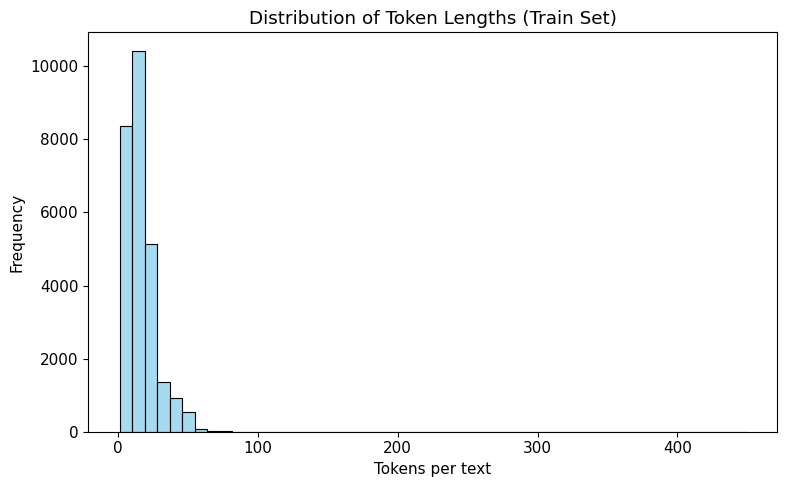

In [7]:
import numpy as np
import seaborn as sns

# Create plots folder
os.makedirs("plots", exist_ok=True)

train_df["text_len"] = train_df["clean_text"].astype(str).apply(lambda x: len(x.split()))
dev_df["text_len"] = dev_df["clean_text"].astype(str).apply(lambda x: len(x.split()))

# Basic stats
print("\n--- Text Length Summary ---")
print(train_df["text_len"].describe())

# Plot length distribution
plt.figure()
sns.histplot(train_df["text_len"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Token Lengths (Train Set)")
plt.xlabel("Tokens per text")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("plots/token_length_distribution.pdf")
plt.show()


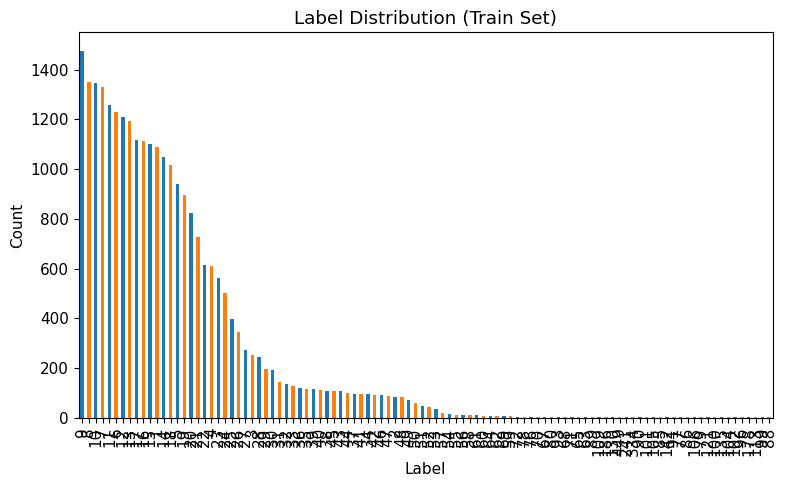


--- Label counts ---
text_len
9      0.054960
8      0.050197
10     0.050123
7      0.049490
11     0.046848
         ...   
96     0.000037
178    0.000037
113    0.000037
99     0.000037
88     0.000037
Name: proportion, Length: 102, dtype: float64


In [9]:
# Adjust 'label' if your column is named differently
label_col = "label" if "label" in train_df.columns else train_df.columns[-1]

plt.figure()
train_df[label_col].value_counts().plot(kind='bar', color=["#1f77b4", "#ff7f0e"])
plt.title("Label Distribution (Train Set)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plots/label_distribution.pdf")
plt.show()

print("\n--- Label counts ---")
print(train_df[label_col].value_counts(normalize=True))


/tmp/ipython-input-809490063.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x="count", y="word", palette="viridis")
/tmp/ipython-input-809490063.py:15: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-809490063.py:15: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipython-input-809490063.py:16: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/top20_words.pdf")
/tmp/ipython-input-809490063.py:16: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.savefig("plots/top20_words.pdf")
/tmp/ipython-input-809490063.py:16: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.save

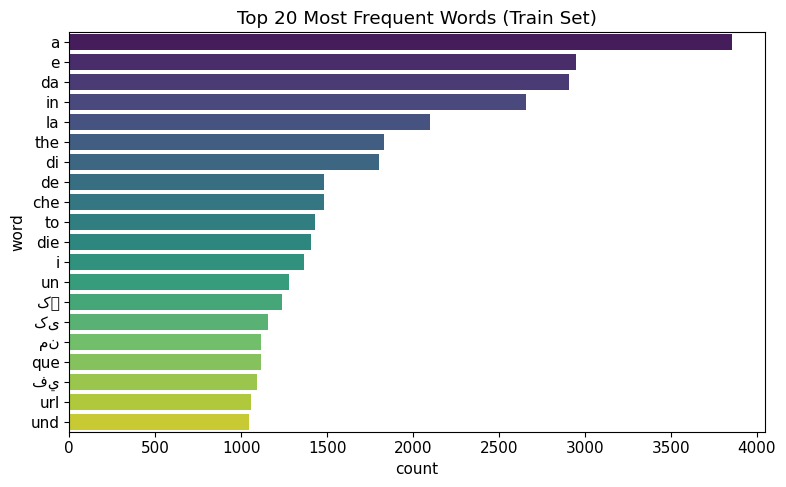

In [10]:
from collections import Counter
import itertools

# Tokenize simple split
tokens = list(itertools.chain.from_iterable(train_df["clean_text"].astype(str).apply(lambda x: x.split())))
counter = Counter(tokens)
most_common = counter.most_common(20)

# Convert to DataFrame for plotting
freq_df = pd.DataFrame(most_common, columns=["word", "count"])

plt.figure()
sns.barplot(data=freq_df, x="count", y="word", palette="viridis")
plt.title("Top 20 Most Frequent Words (Train Set)")
plt.tight_layout()
plt.savefig("plots/top20_words.pdf")
plt.show()


In [11]:
summary = {
    "train_size": len(train_df),
    "dev_size": len(dev_df),
    "avg_text_length": round(train_df["text_len"].mean(), 2),
    "vocab_size": len(counter)
}
summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
summary_df.to_csv("plots/dataset_summary.csv", index=False)
summary_df


,Metric,Value
0,train_size,26874.00
1,dev_size,1338.00
2,avg_text_length,15.81
3,vocab_size,117516.00
